In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from json2dag.models.DAG import DAG
from json2dag.models.relations import Linear, GeometricAdstock, Hill
import numpy as np
import pymc as pm
import pymc_experimental as pmx
from IPython.display import Image
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
linear = Linear()
hill = Hill()
geometric_adstock = GeometricAdstock(normalize=True, l_max=12)
media_transform = (geometric_adstock | hill | linear)
media_transform


geometric_adstock l_max=12, normalize=True, axis=0->hill  ->linear  

In [4]:
media_transform.op_name = 'media_transform'

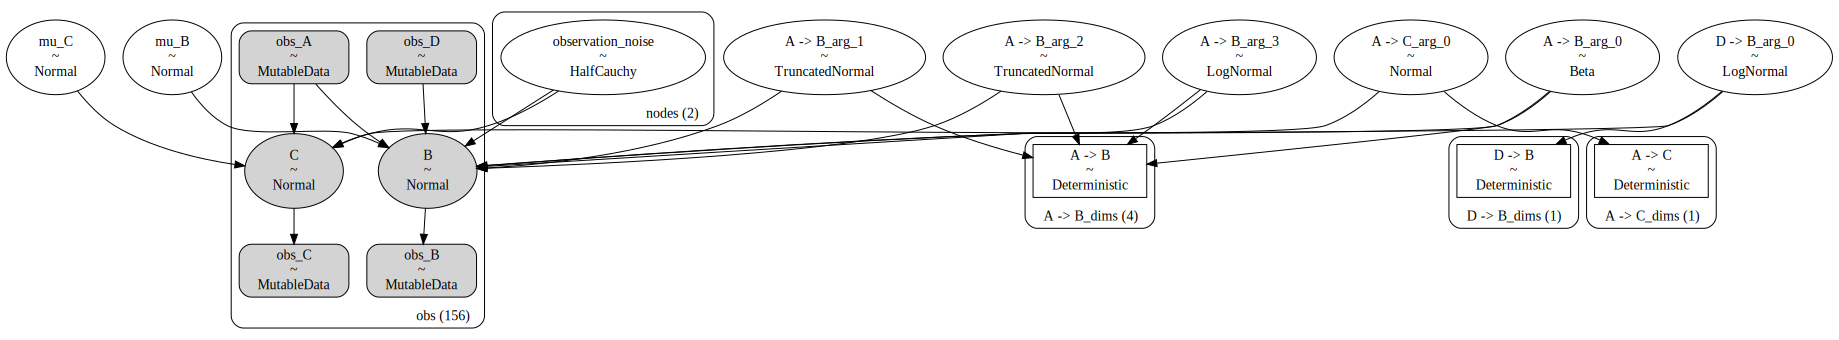

In [5]:
sample_size = 156
causes = {"A": [dict(name="B", 
                     op=media_transform, 
                     prior_constraint=[
                         'zero_one',
                         'positive',
                         'not2big',
                         'lognormal'
                        ]),
                dict(name="C")], 
          "D": [
            dict(name="B", prior_constraint=['lognormal']), 
            dict(name="A")
            ]
          }

my_dag = DAG.dag_from_causes_dict(causes)
t = np.linspace(0, 1, sample_size)
D = 4*np.sin(2*np.pi*t*3)+np.random.normal(0, 1, size=sample_size)
A = np.maximum(0 + 2*D + np.random.normal(0, 5, size=sample_size), 0)
standard = np.quantile(A[A>0], .5)
C = 1.0 + 1*A + np.random.normal(0, 5, size=sample_size)
B = 3.0 + media_transform(A, .1, 5, 1.2, 5).eval() + 2*D + np.random.normal(0, .1, size=sample_size)
for node in my_dag.nodes:
    if node.name in ["B", "C"]:
        node.observed = True

my_dag_model = my_dag.model_from_dag(observations={'A': A, "B": B, "C": C, "D": D})
pm.model_to_graphviz(my_dag_model)

In [6]:
my_dag.get_paths("D", "B")

[[D -> B], [D -> A, A -> B]]

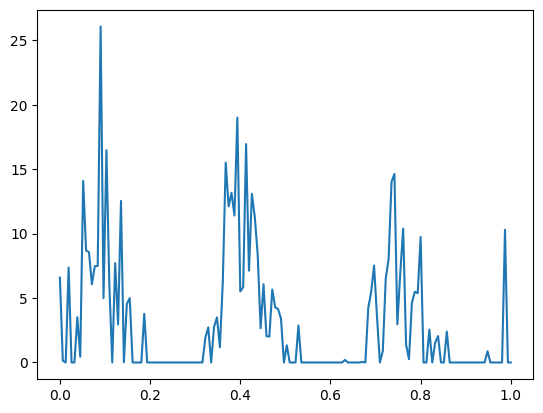

In [7]:
plt.plot(t, A)

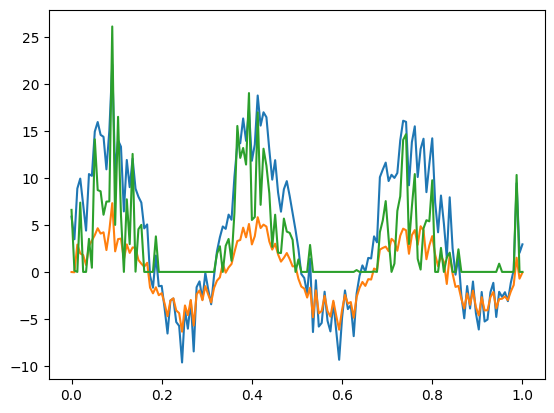

In [8]:
plt.plot(t, B)
plt.plot(t, D)
plt.plot(t, A)

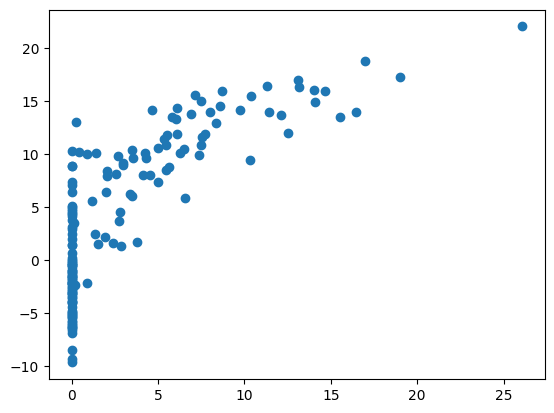

In [9]:
plt.scatter(A, B)

In [10]:
my_dag.sample(1000, tune=1000, target_accept=.98, nuts_sampler="numpyro")

Compiling...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Compilation time = 0:00:04.235281
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.973592
Transforming variables...
Transformation time = 0:00:00.198802


In [11]:
my_dag.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
D -> B[beta]   1.994  0.006   1.984    2.005      0.000    0.000    2671.0   
A -> B[decay]  0.100  0.007   0.088    0.113      0.000    0.000    3299.0   
A -> B[K]      5.061  0.247   4.591    5.495      0.006    0.004    1776.0   
A -> B[S]      1.167  0.043   1.085    1.243      0.001    0.001    1531.0   
A -> B[beta]   5.111  0.153   4.837    5.398      0.004    0.003    1513.0   
A -> C[beta]   1.065  0.087   0.903    1.225      0.002    0.001    2783.0   
mu_B           2.978  0.021   2.941    3.018      0.000    0.000    2352.0   
mu_C           0.593  0.495  -0.321    1.511      0.009    0.007    3019.0   

               ess_tail  r_hat  
D -> B[beta]     2876.0    1.0  
A -> B[decay]    2649.0    1.0  
A -> B[K]        2444.0    1.0  
A -> B[S]        2129.0    1.0  
A -> B[beta]     2168.0    1.0  
A -> C[beta]     2718.0    1.0  
mu_B             2550.0    1.0  
mu_C             3059.0    1.0

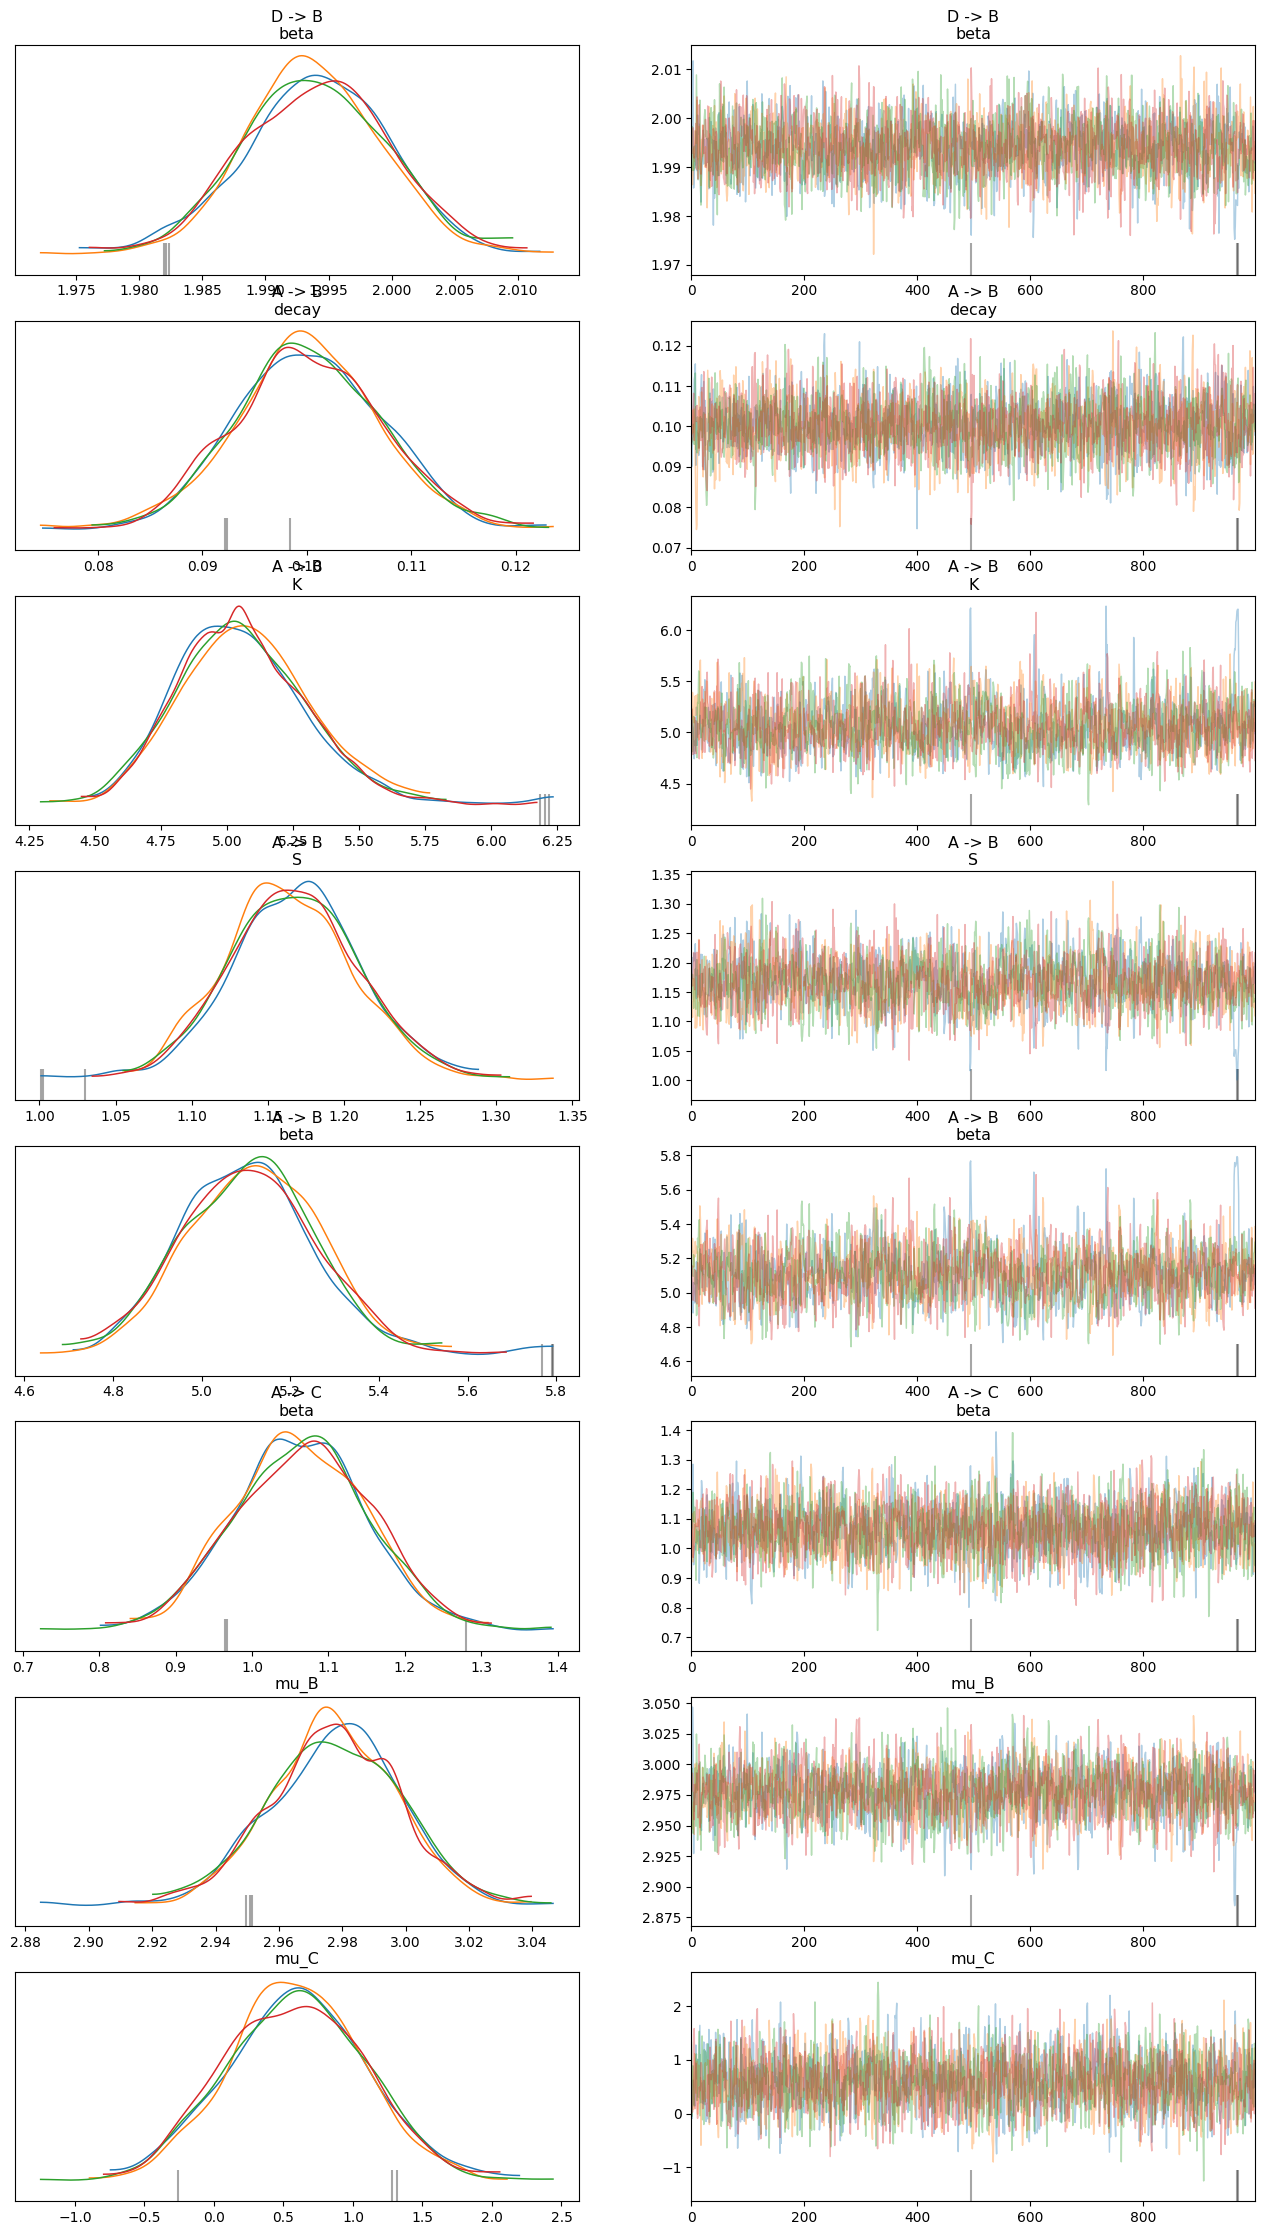

In [12]:
pm.plot_trace(
  my_dag.trace, 
  var_names=[f"{edge}" for edge in my_dag.edges if edge.child.observed] 
  + [f'mu_{node.name}' for node in my_dag.nodes if node.observed],
  compact=False,
  figsize=(16, 28)
);

In [13]:
np.array([my_dag.trace.posterior[f'A -> B_arg_{i}'].mean().values for i in range(media_transform.n_args)])

array([0.10013628, 5.06070787, 1.16659191, 5.11076737])

In [14]:
x = np.linspace(0, 26, 100)
offset = (geometric_adstock(A[:, np.newaxis], my_dag.trace.posterior[f'A -> B_arg_0'].stack(sample=('draw', 'chain')).values[:, np.newaxis]).eval() - A[:, np.newaxis]).mean()
hill_test = Hill()(x[:, np.newaxis]+offset, *list(np.array([my_dag.trace.posterior[f'A -> B_arg_{i}'].stack(samples=('chain', 'draw')).values[np.newaxis, :] for i in range(media_transform.n_args)]))[1:3]) * my_dag.trace.posterior[f'A -> B_arg_3'].stack(samples=('chain', 'draw')).values[np.newaxis, :]

Text(0.5, 1.0, 'Response from A Impressions')

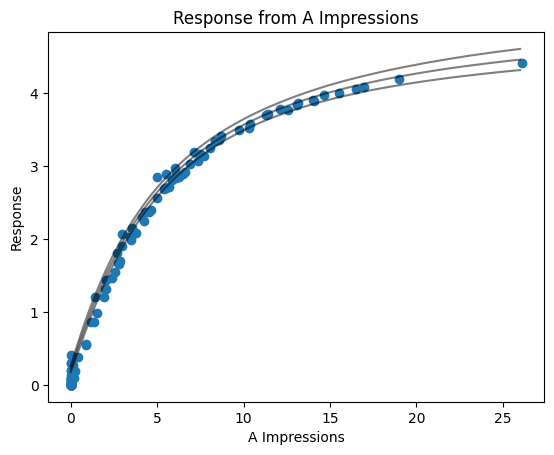

In [15]:
plt.scatter(A, media_transform(A, .05, 5, 1.2, 5).eval())
plt.plot(x, 
         hill_test.mean(1), 
         color='black', 
         alpha=.5
        )

plt.plot(x, 
         np.quantile(hill_test, .975, axis=1), 
         color='black', 
         alpha=.5
        )

plt.plot(x, 
         np.quantile(hill_test, .025, axis=1), 
         color='black', 
         alpha=.5
        )
plt.xlabel("A Impressions")
plt.ylabel("Response")
plt.title("Response from A Impressions")

In [16]:
from IPython.display import display
from json2dag.models.utils import is_path_causal

In [40]:
def do(dag, value, node_name, params=None):
  if params is None:
    params = {}
  for node in dag.nodes:
    if node.name == node_name:
      node.value = value + node.value
  for edge in dag.get_node_causal_edges(node_name):
    do(dag, edge.apply(params.get(str(edge), 0)), edge.child.name, params)

[[C -> B], [C -> F, B -> F], [C -> A, A -> B], [C -> A, A -> D, B -> D], [E -> C, E -> B]]


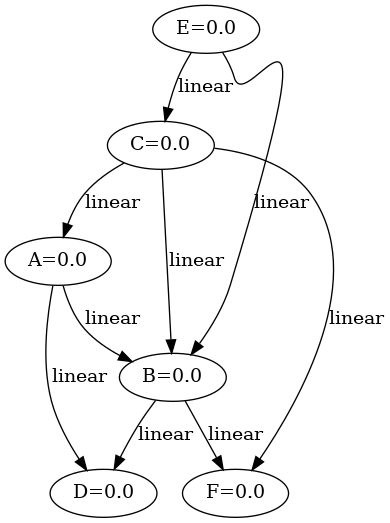

True


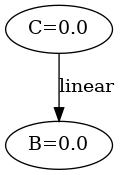

False


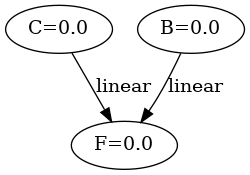

True


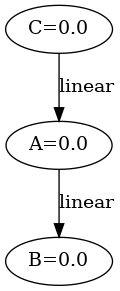

False


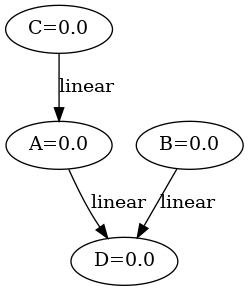

False


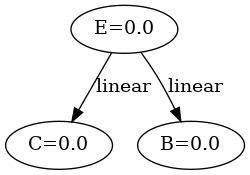

In [41]:
new_test = {"A": ["D","B"], "C": ["A", "B", "F"], "E": ["B", "C"],"B":["F", "D"]}
test_dag = DAG.dag_from_causes_dict(new_test)
edge_lists = test_dag.get_paths("C", "B")
print(edge_lists)
display(Image(test_dag.graph))
for edge_list in edge_lists:
    print(is_path_causal(edge_list, "C", "B"))
    display(Image(DAG.dag_from_edge_list(edge_list).graph))

In [42]:
default_params = {str(edge): np.random.normal() for edge in test_dag.edges}

In [43]:
default_params

{'C -> B': -1.5417543945880319,
 'A -> B': 1.3425724950174847,
 'A -> D': 0.05128933893937775,
 'E -> B': 1.409320042204156,
 'C -> F': -0.23916607517798577,
 'B -> F': -1.3711975421514522,
 'B -> D': -0.3814794254615587,
 'C -> A': -0.2862978989562043,
 'E -> C': 0.3595337418994477}

In [44]:
do(test_dag, np.random.normal(0, 1, 100), "E", params=default_params)

In [45]:
-0.1428991827470287*(-0.55697)+(-0.39352*-0.504) + 1.4*-0.46781

-0.37700936218538744

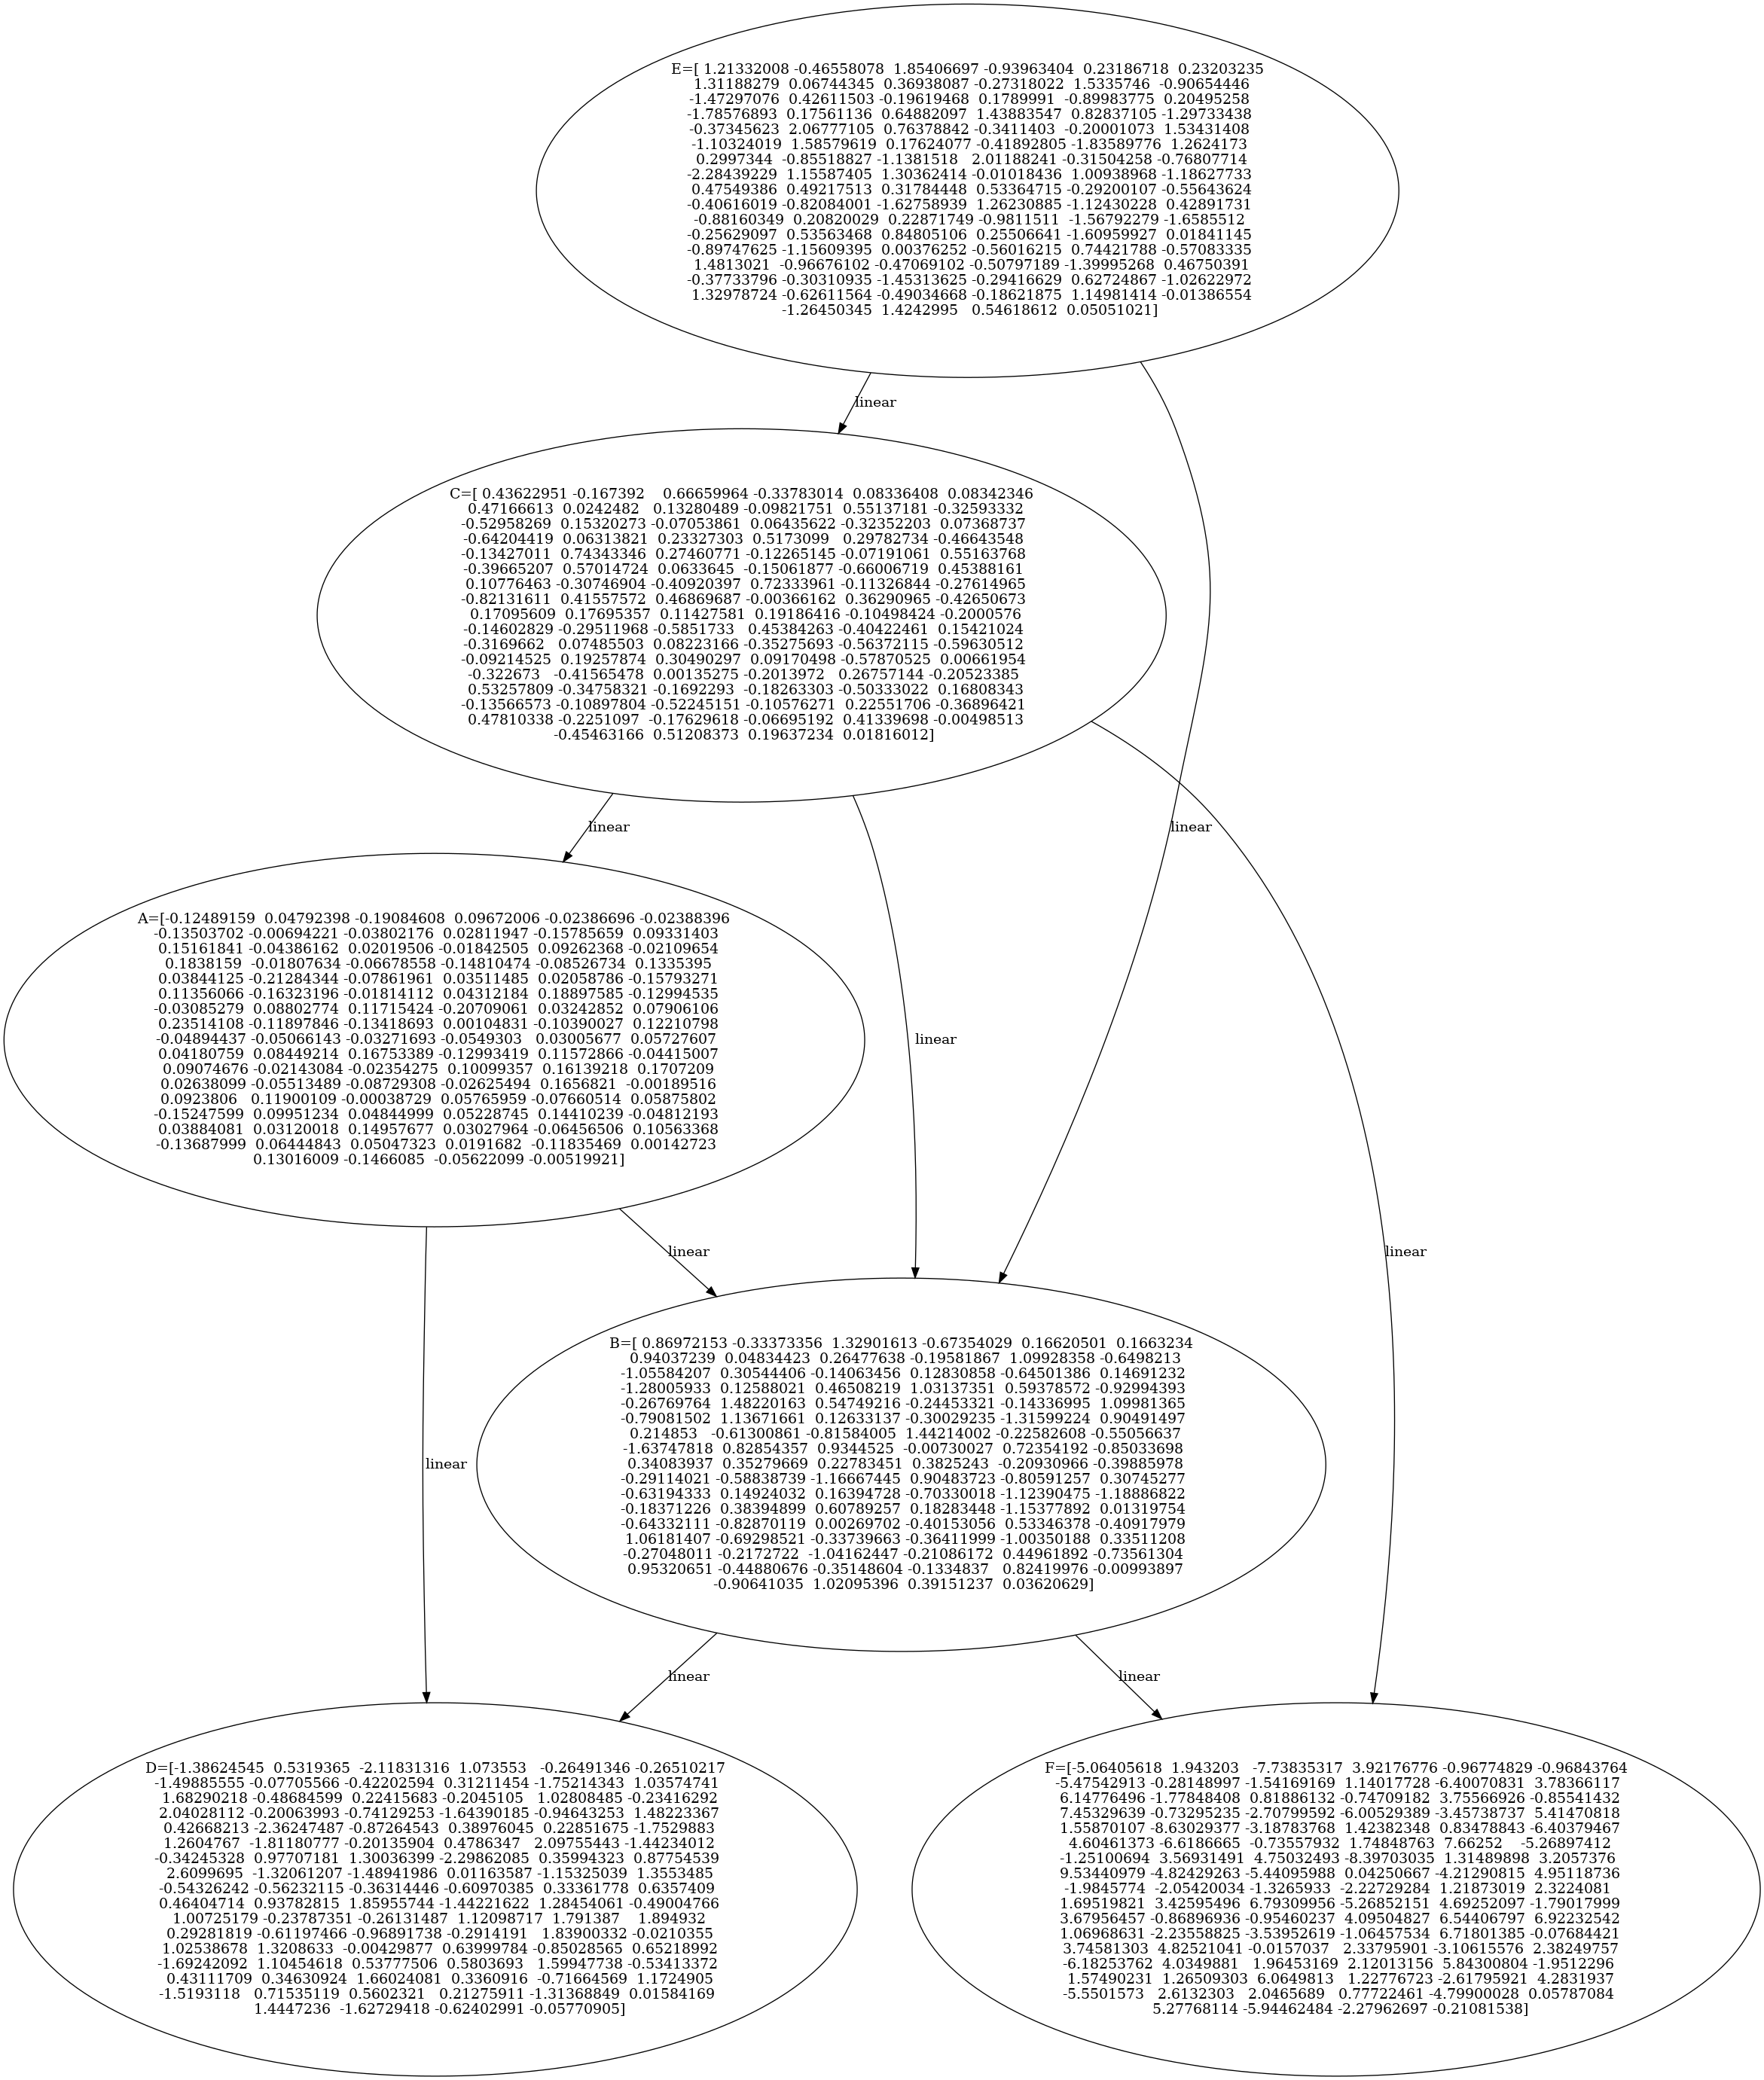

In [46]:
Image(test_dag.graph)

In [47]:
test_dag

digraph {
	A [label="A=[-0.12489159  0.04792398 -0.19084608  0.09672006 -0.02386696 -0.02388396
 -0.13503702 -0.00694221 -0.03802176  0.02811947 -0.15785659  0.09331403
  0.15161841 -0.04386162  0.02019506 -0.01842505  0.09262368 -0.02109654
  0.1838159  -0.01807634 -0.06678558 -0.14810474 -0.08526734  0.1335395
  0.03844125 -0.21284344 -0.07861961  0.03511485  0.02058786 -0.15793271
  0.11356066 -0.16323196 -0.01814112  0.04312184  0.18897585 -0.12994535
 -0.03085279  0.08802774  0.11715424 -0.20709061  0.03242852  0.07906106
  0.23514108 -0.11897846 -0.13418693  0.00104831 -0.10390027  0.12210798
 -0.04894437 -0.05066143 -0.03271693 -0.0549303   0.03005677  0.05727607
  0.04180759  0.08449214  0.16753389 -0.12993419  0.11572866 -0.04415007
  0.09074676 -0.02143084 -0.02354275  0.10099357  0.16139218  0.1707209
  0.02638099 -0.05513489 -0.08729308 -0.02625494  0.1656821  -0.00189516
  0.0923806   0.11900109 -0.00038729  0.05765959 -0.07660514  0.05875802
 -0.15247599  0.09951234  0.04

In [66]:
is_path_causal(edge_lists[2], "C", "B")  

False

In [45]:
new_test = {"D": ["A", "B"], "A": ["B", "C"], "B": ["C"], "E": ["B"]}
test_dag = DAG.dag_from_causes_dict(new_test)
estimator = get_estimator(test_dag, "D", "B")

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm

In [21]:
sample_size = 10
t = np.abs(np.random.normal(0, 2, size=sample_size))
t = t/t.max()
obs_size = 300
n = np.random.geometric(1./obs_size, size=sample_size)+199
p = .9*t + 0.01
s = np.random.binomial(n, p)
x = 3*p + 1 + np.random.normal(0, .5, size=sample_size)


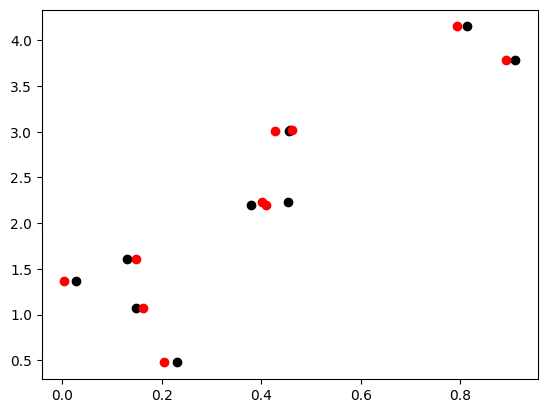

In [22]:
plt.scatter(p, x, c='k')
plt.scatter(s/n, x, c='r')

In [23]:
with pm.Model() as measurement:
  p_true = pm.Beta('p_true', 1, 1, shape=sample_size)
  p_obs = pm.Binomial('p_obs', n=n, p=p_true, observed=s)
  sigma = pm.HalfNormal('sigma', sigma=1)
  beta = pm.Normal('beta', mu=0, sigma=10)
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  x_obs = pm.Normal('x_obs', mu=beta*p_true+alpha, sigma=sigma, observed=x)

In [24]:
with measurement:
  trace = pm.sample(5000, tune=10000, target_accept=.99, nuts_sampler="numpyro")

Compiling...
Compilation time = 0:00:01.372388
Sampling...


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Sampling time = 0:00:02.266177
Transforming variables...
Transforming variables...
Transformation time = 0:00:00.107496


In [25]:
pm.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta       3.795  0.796   2.275    5.305      0.007    0.005   14582.0   
alpha      0.802  0.376   0.065    1.504      0.003    0.002   14261.0   
p_true[0]  0.163  0.023   0.122    0.206      0.000    0.000   33237.0   
p_true[1]  0.793  0.019   0.757    0.830      0.000    0.000   32415.0   
p_true[2]  0.435  0.034   0.374    0.501      0.000    0.000   29045.0   
p_true[3]  0.152  0.016   0.123    0.181      0.000    0.000   32777.0   
p_true[4]  0.409  0.030   0.351    0.464      0.000    0.000   32028.0   
p_true[5]  0.199  0.022   0.159    0.242      0.000    0.000   30884.0   
p_true[6]  0.010  0.007   0.000    0.022      0.000    0.000   25511.0   
p_true[7]  0.401  0.024   0.355    0.445      0.000    0.000   34012.0   
p_true[8]  0.465  0.025   0.418    0.513      0.000    0.000   33215.0   
p_true[9]  0.887  0.018   0.851    0.920      0.000    0.000   33072.0   
sigma      0.640  0.187   0.345    0.974      0.002    0.001   16285.0   

           ess_tail  r_hat  
beta        12097.0    1.0  
alpha       11458.0    1.0  
p_true[0]   13500.0    1.0  
p_true[1]   15044.0    1.0  
p_true[2]   14154.0    1.0  
p_true[3]   12910.0    1.0  
p_true[4]   14027.0    1.0  
p_true[5]   13319.0    1.0  
p_true[6]   11602.0    1.0  
p_true[7]   14750.0    1.0  
p_true[8]   13608.0    1.0  
p_true[9]   13889.0    1.0  
sigma       11853.0    1.0

array([[<Axes: title={'center': 'p_true'}>,
        <Axes: title={'center': 'p_true'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

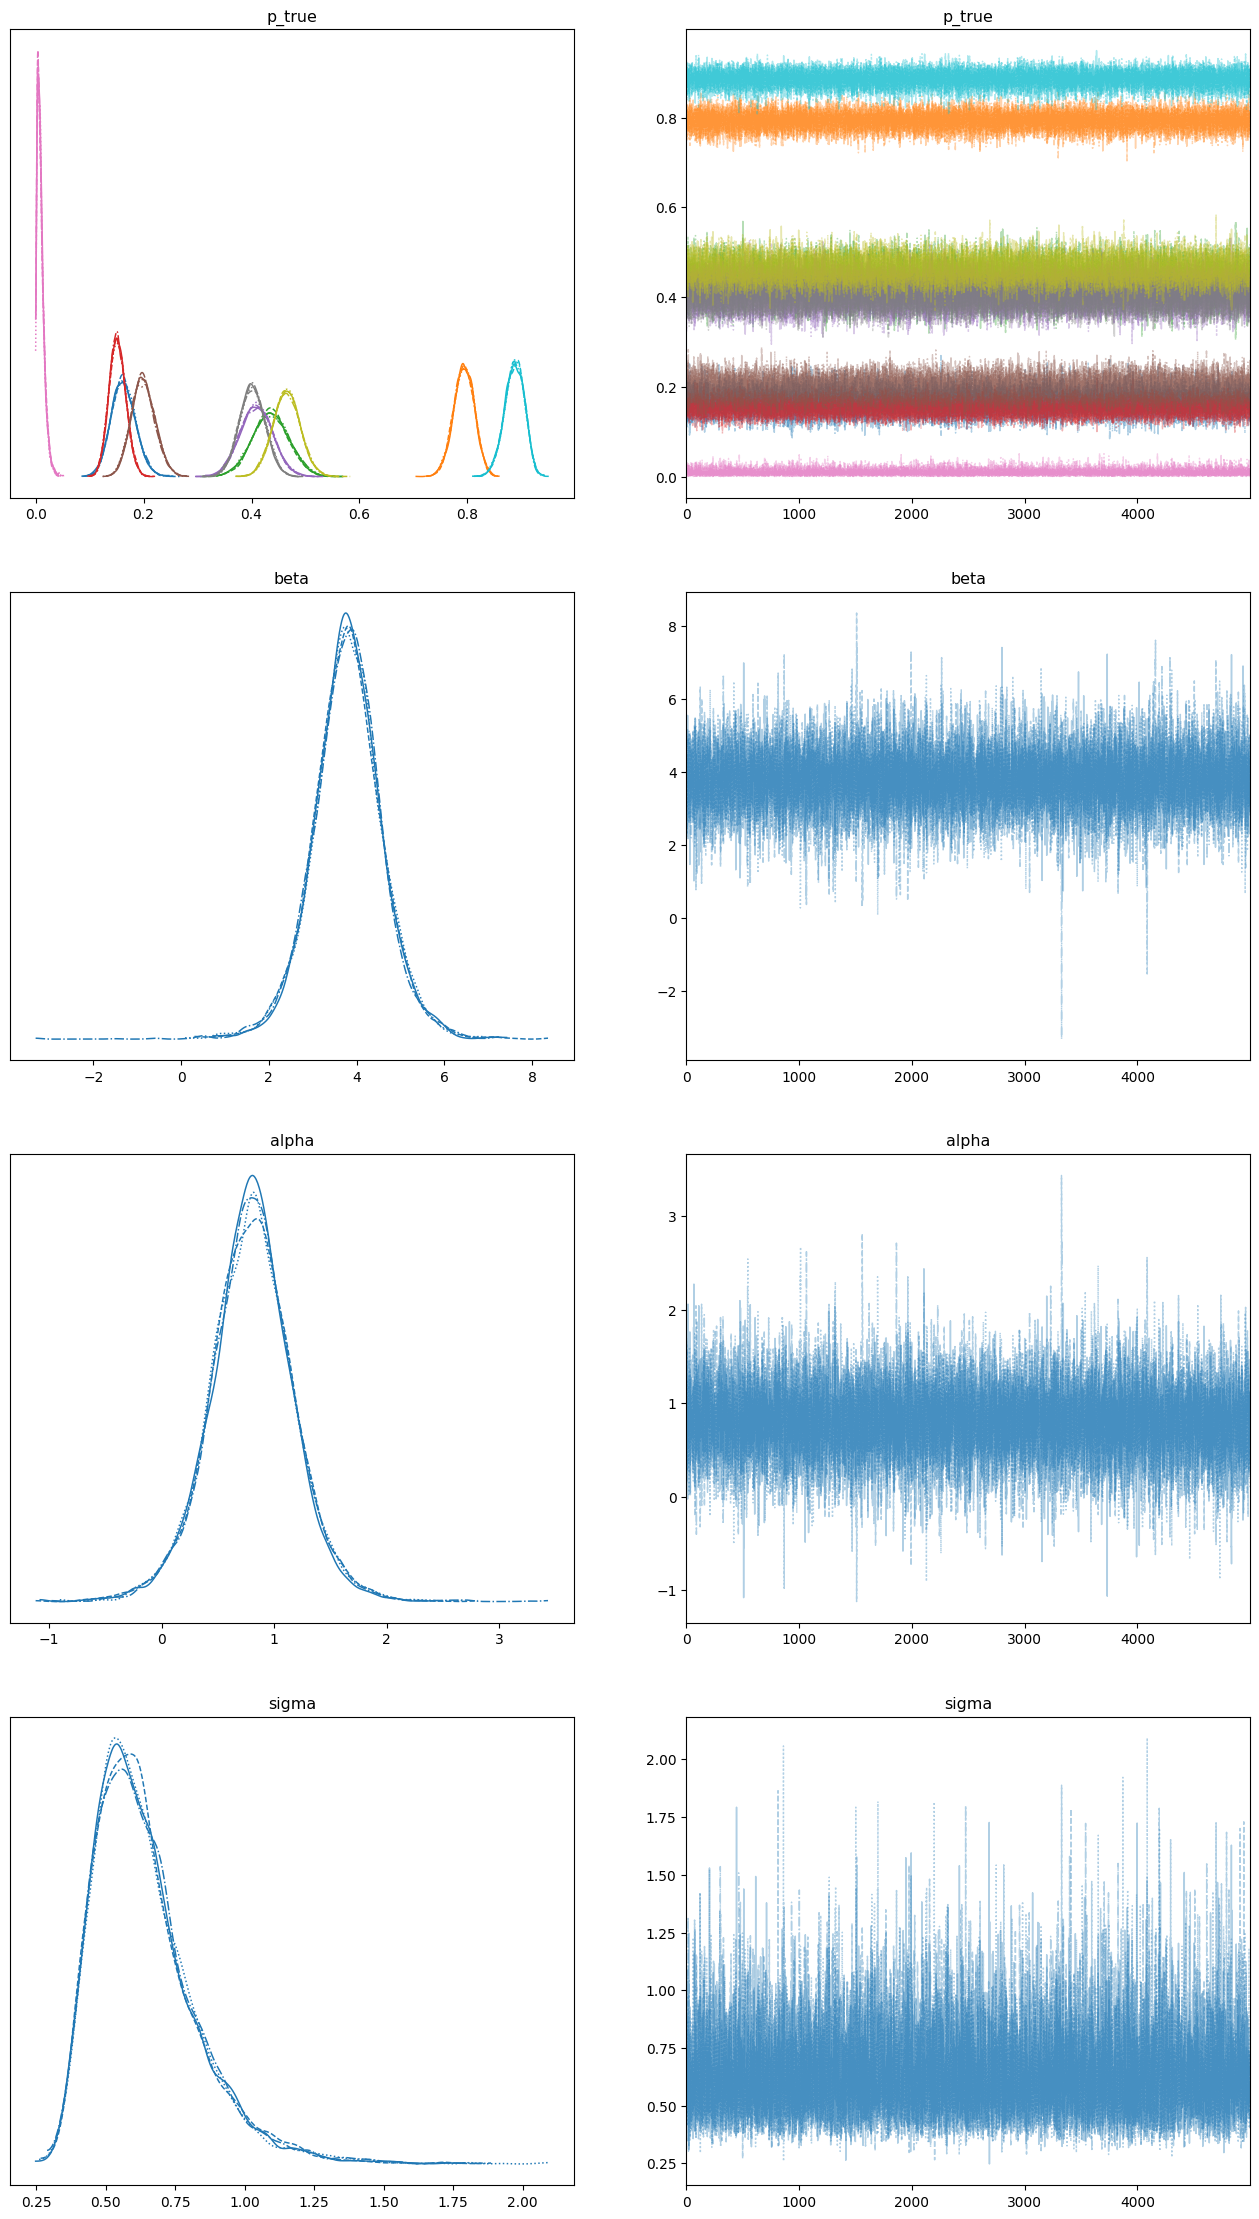

In [26]:
pm.plot_trace(trace, var_names=['p_true', 'beta', 'alpha', 'sigma'], compact=True, figsize=(16, 28))

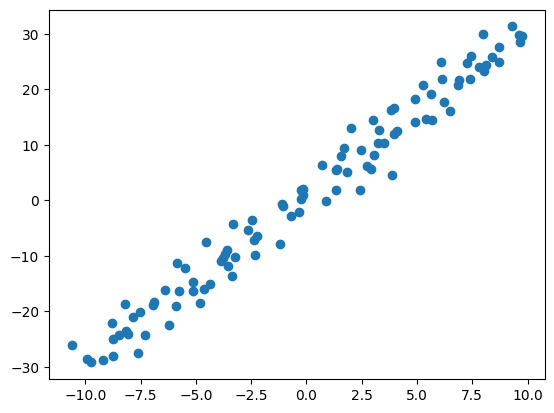

In [27]:
n_samples = 100
x = np.linspace(-10, 10, n_samples)
x_obs = x+np.random.normal(0, 1, size=n_samples)
y = 3*x + 1 + np.random.normal(0, 1, size=n_samples)
plt.plot(x_obs, y, 'o')

In [28]:
with pm.Model() as gaussian_obs_noise:
  beta = pm.Normal('beta', mu=0, sigma=10)
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  sigma_measure_noise = pm.HalfNormal('sigma_measure_noise', sigma=1)
  sigma = pm.HalfNormal('sigma', sigma=1)
  
  true_x = pm.Normal('true_x', mu=0, sigma=5, shape=n_samples)
  pm.Normal('x_obs', mu=true_x, sigma=sigma_measure_noise, observed=x_obs)
  pm.Normal('y_obs', mu=beta*true_x+alpha, sigma=sigma, observed=y)

In [29]:
with gaussian_obs_noise:
  trace = pm.sample(15000, tune=30000, target_accept=.99, nuts_sampler="numpyro")

Compiling...
Compilation time = 0:00:00.899541
Sampling...


  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

Sampling time = 0:00:14.855076
Transforming variables...
Transforming variables...
Transformation time = 0:00:00.149004


In [30]:
pm.summary(trace, var_names=['beta', 'alpha', 'sigma', 'sigma_measure_noise'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta                 3.093  0.055   2.988    3.197      0.001    0.001   
alpha                0.903  0.288   0.360    1.445      0.006    0.005   
sigma                0.881  0.638   0.030    2.067      0.046    0.032   
sigma_measure_noise  0.891  0.134   0.628    1.112      0.005    0.004   

                     ess_bulk  ess_tail  r_hat  
beta                   1362.0    2613.0   1.01  
alpha                  2020.0    2807.0   1.00  
sigma                   131.0      92.0   1.03  
sigma_measure_noise     594.0    1414.0   1.00

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'sigma_measure_noise'}>,
        <Axes: title={'center': 'sigma_measure_noise'}>]], dtype=object)

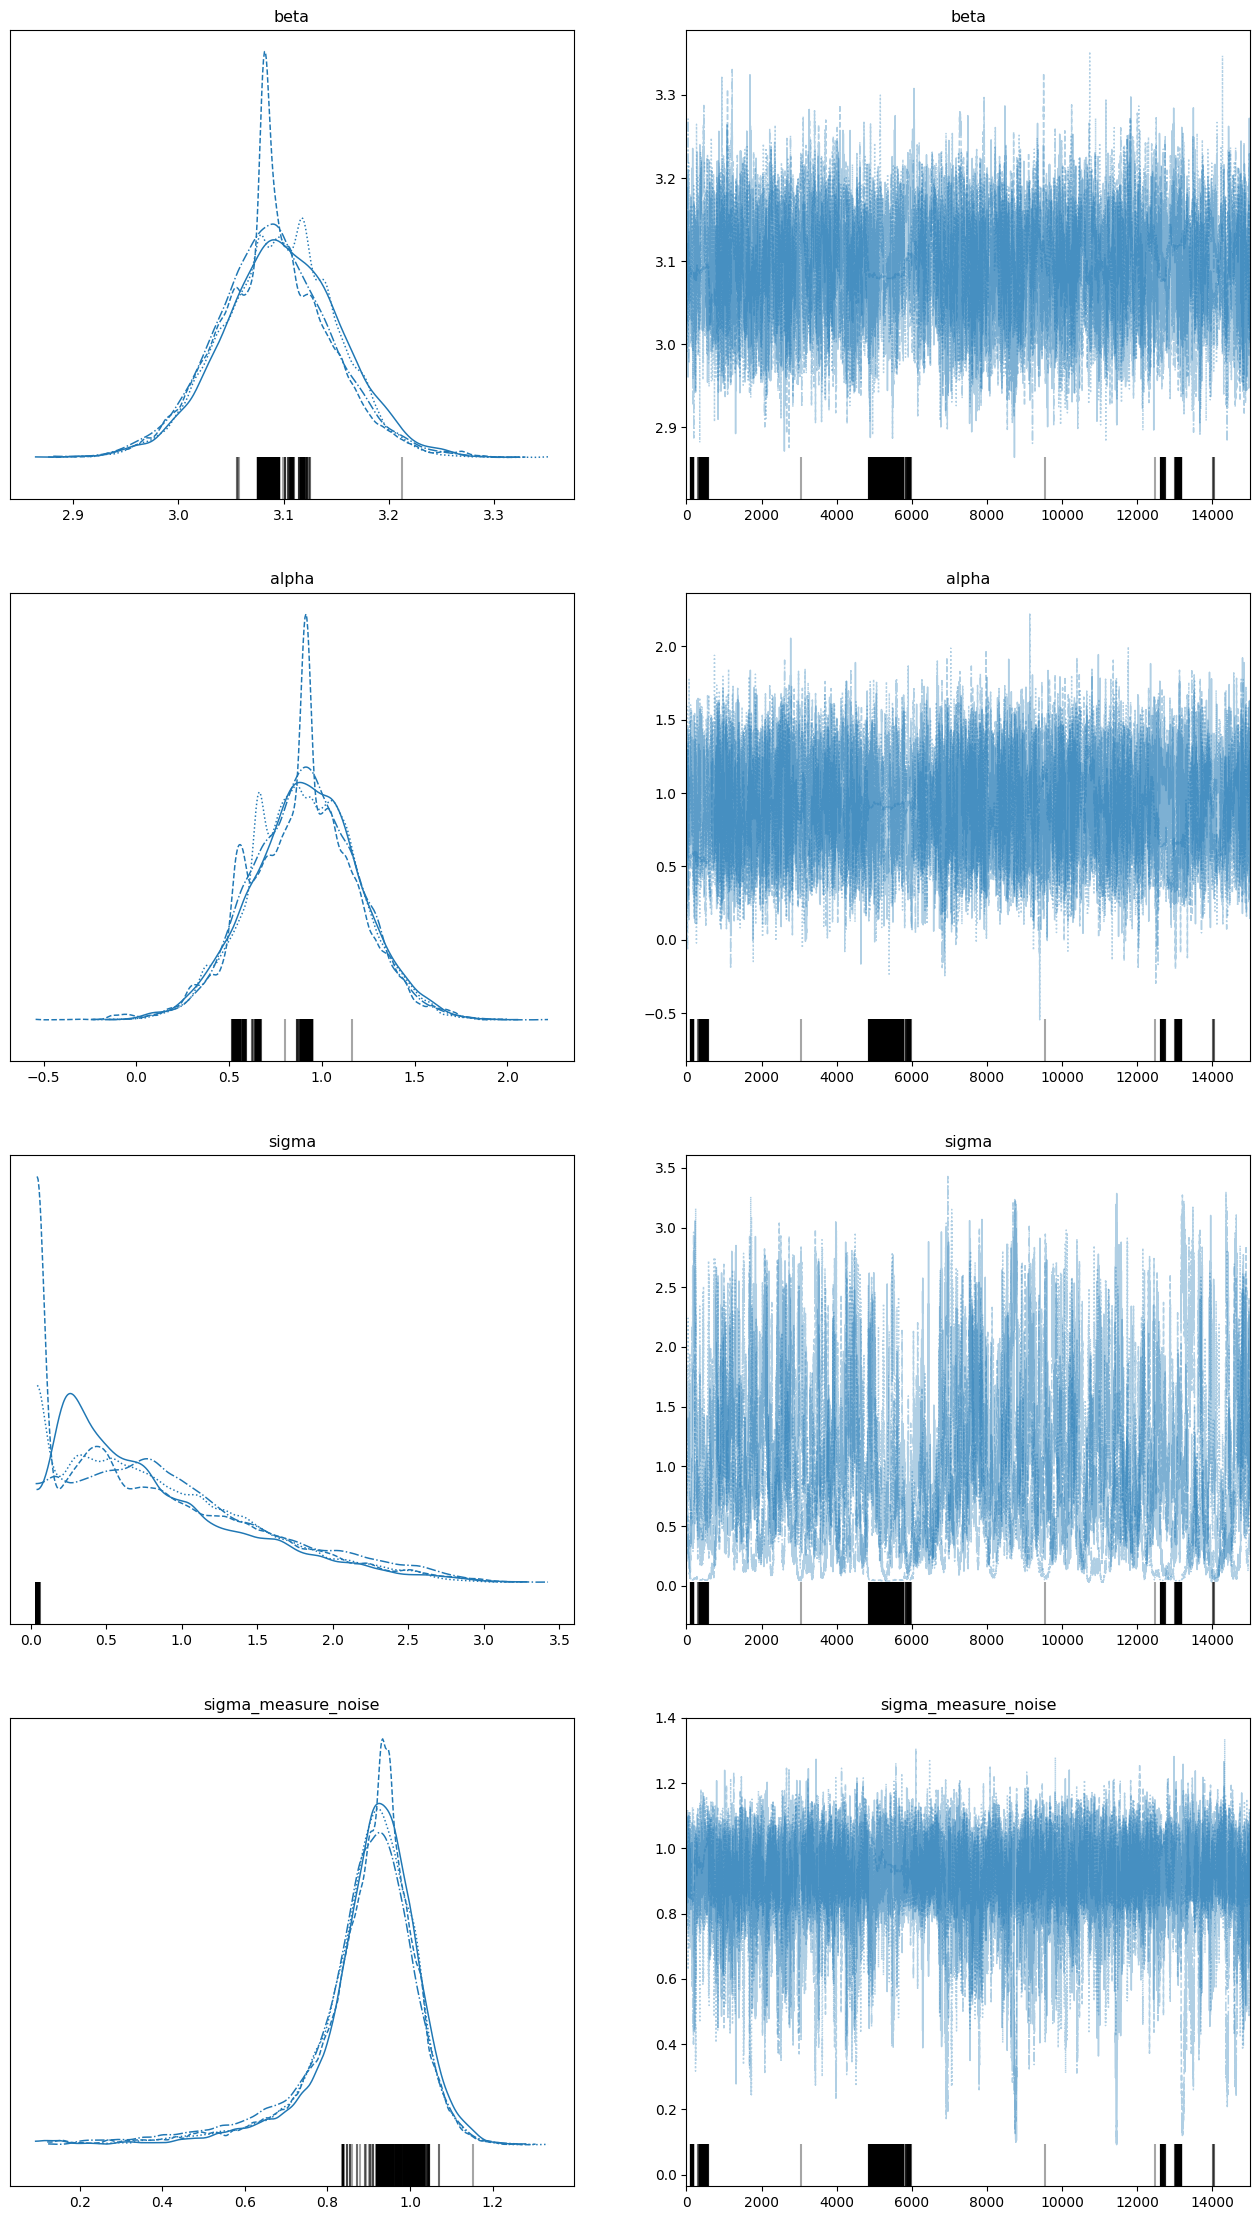

In [31]:
pm.plot_trace(trace, var_names=['beta', 'alpha', 'sigma', 'sigma_measure_noise'], compact=True, figsize=(16, 28))

In [113]:
mus = [-1, 1, 5]
sigmas = [.5, .1, 1]
sample_sizes = [300, 100, 600]
x = np.hstack([np.random.normal(mu, sigma, size=n) for mu, sigma, n in zip(mus, sigmas, sample_sizes)])
np.random.shuffle(x)

In [114]:
with pm.Model() as mixture_model:
  w = pm.Dirichlet('w', a=np.ones(3))
  mu = pm.Normal('mu', mu=0, sigma=10, shape=3, transform=pm.distributions.transforms.ordered, initval=[-1, 1, 2])
  sigma = pm.HalfNormal('sigma', sigma=10, shape=3)
  choice = pm.Categorical('choice', p=w, shape=len(x), dims='obs')
  pm.Normal('x', mu=mu[choice], sigma=sigma[choice], observed=x, dims='obs')

In [115]:
with mixture_model:
  trace = pm.sample(1000, tune=1000, target_accept=.99)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w, mu, sigma]
>CategoricalGibbsMetropolis: [choice]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [112]:
pm.summary(trace, var_names=['w', 'mu', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w[0]      0.325  0.046   0.273    0.417      0.022    0.017       7.0   
w[1]      0.165  0.131   0.069    0.477      0.061    0.046       8.0   
w[2]      0.510  0.170   0.118    0.640      0.081    0.062       7.0   
mu[0]    -0.885  0.226  -1.075   -0.454      0.111    0.085       7.0   
mu[1]     1.947  1.635   0.977    4.897      0.813    0.623       7.0   
mu[2]     5.003  0.173   4.827    5.292      0.061    0.045       9.0   
sigma[0]  0.616  0.220   0.446    1.023      0.109    0.083       7.0   
sigma[1]  0.342  0.407   0.090    1.113      0.200    0.153       7.0   
sigma[2]  1.005  0.127   0.714    1.112      0.013    0.009      55.0   

          ess_tail  r_hat  
w[0]          31.0   1.53  
w[1]          11.0   1.51  
w[2]          11.0   1.58  
mu[0]         30.0   1.53  
mu[1]         20.0   1.55  
mu[2]         15.0   1.39  
sigma[0]      32.0   1.53  
sigma[1]      24.0   1.53  
sigma[2]      33.0   1.27

array([[<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'choice'}>,
        <Axes: title={'center': 'choice'}>]], dtype=object)

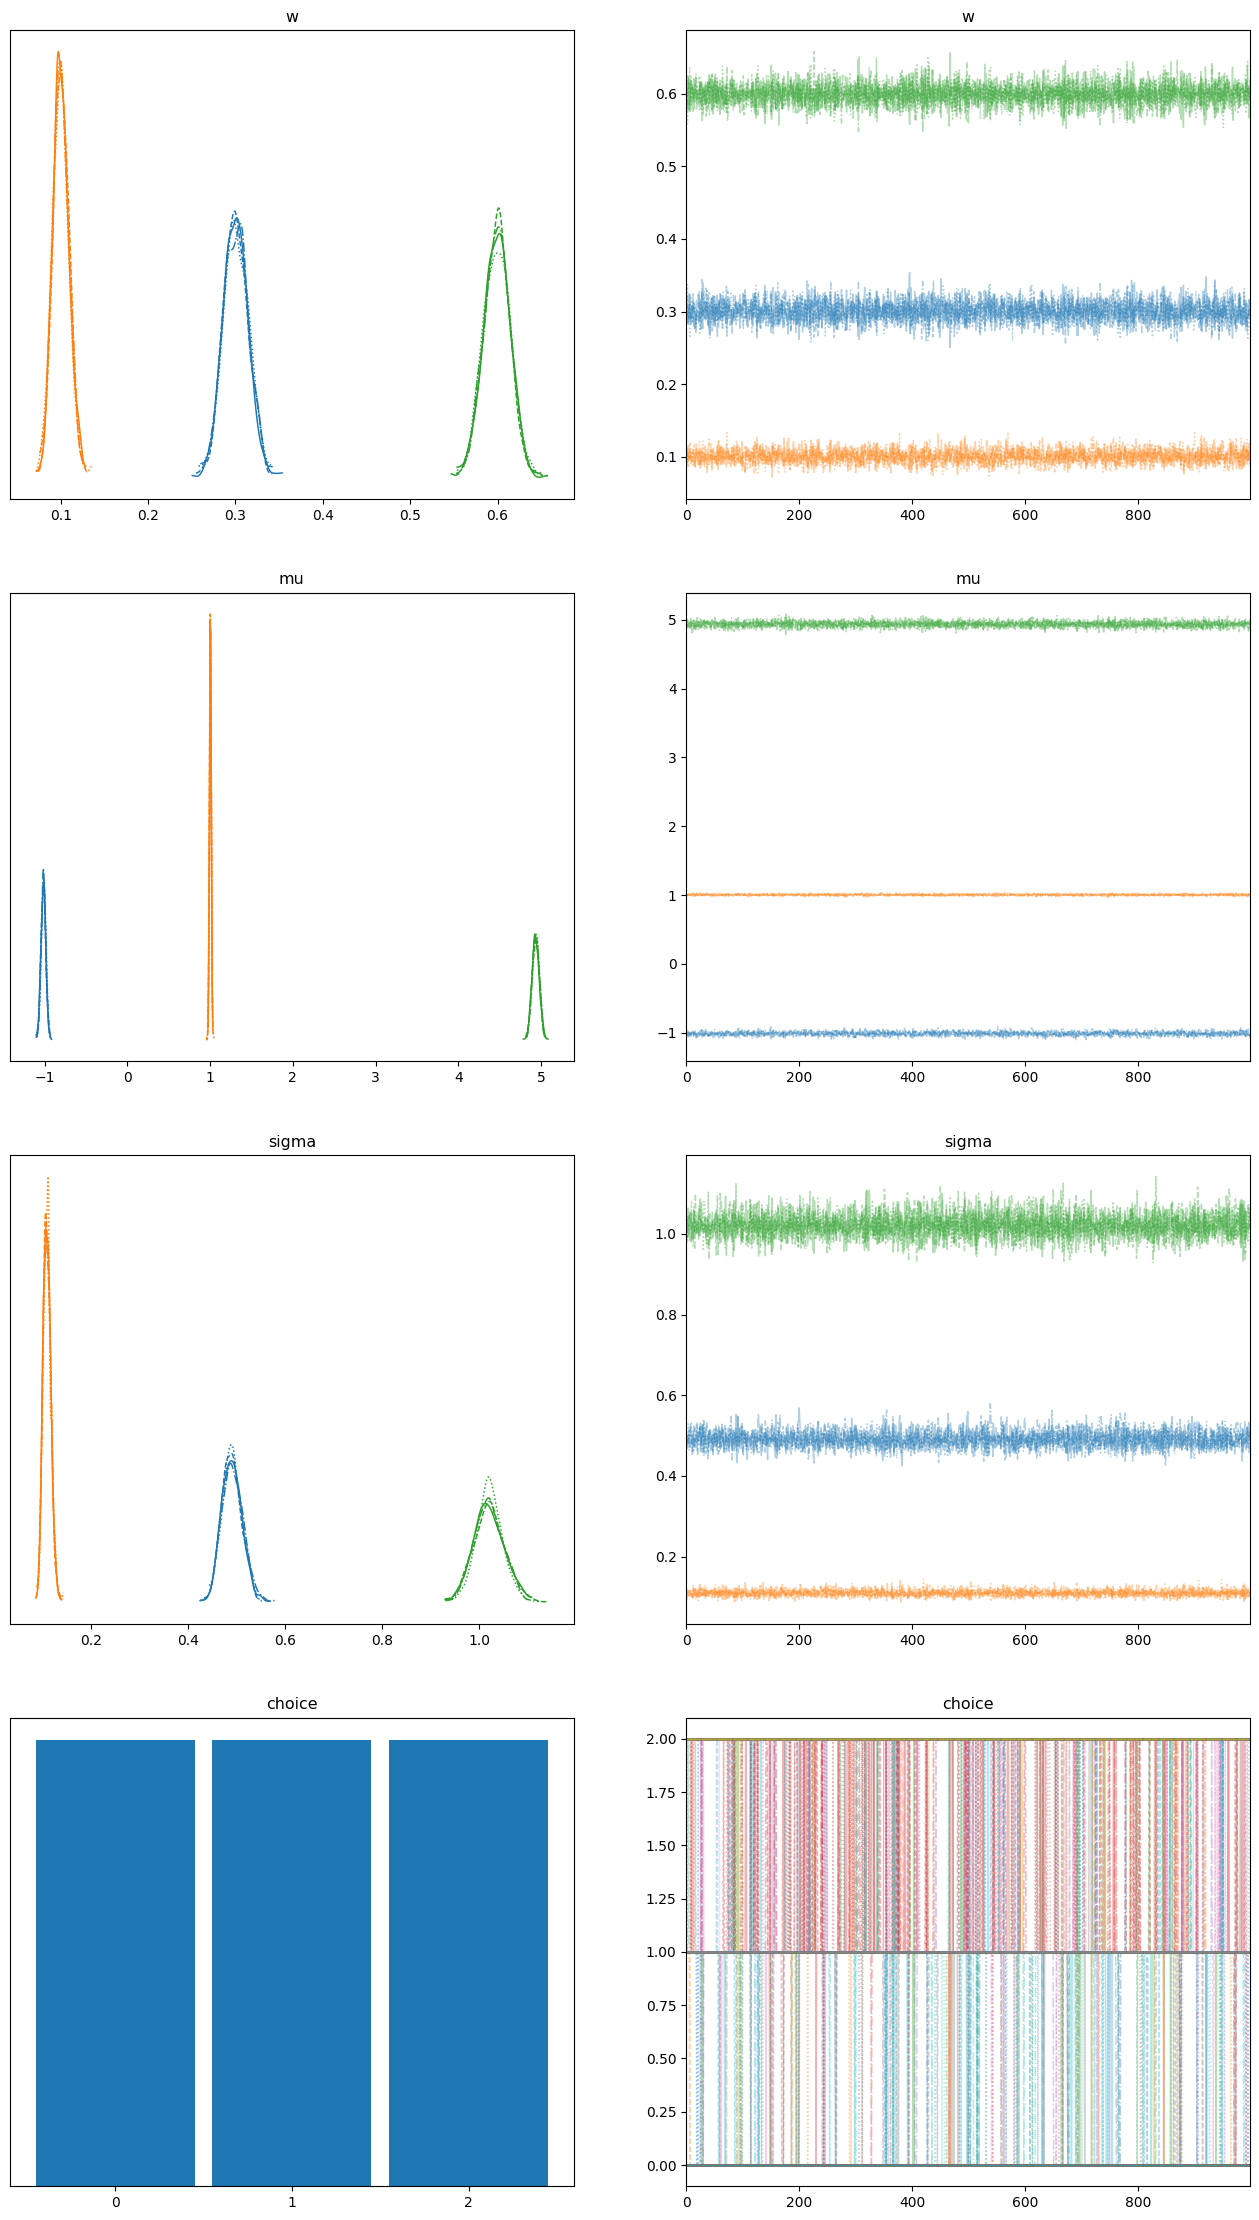

In [99]:
pm.plot_trace(trace, var_names=['w', 'mu', 'sigma'], compact=True, figsize=(16, 28))

In [100]:
choices = trace.posterior['choice'].median(dim=('chain', 'draw')).values.astype(int)

choice
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
Name: x, dtype: object

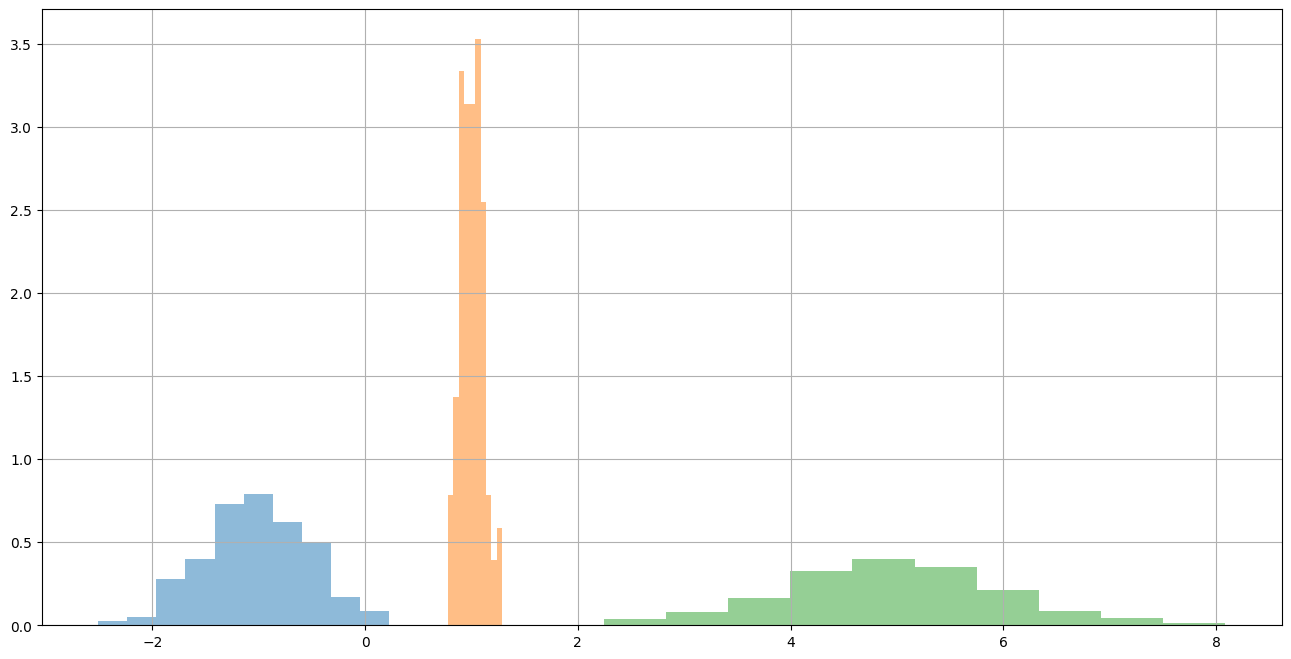

In [109]:
pd.DataFrame({'x': x, 'choice': choices}).groupby('choice').x.hist(bins=10, alpha=.5, density=True, figsize=(16, 8))